## 消费信贷逾期预测建模

**实验任务：**建立消费信贷逾期预测模型，预测两年内是否会有90天以上的债务逾期

**实验课时：**4课时

**实验目的：**

* 理解机器学习的完整流程；
* 掌握机器学习的实际应用。

### 1. 案例数据

本节例子基于某银行的客户信用情况数据，目标是建立模型预测两年内是否会有90天以上的债务逾期，包含250,000个样本，每个样本包含11个属性，如下表所示


属性  | 定义 
------|------
SeriousDlqin2yrs | 两年内是否有90天以上债务逾期，“Y”为有，“N”为无  
RevolvingUtilizationOfUnsecuredLines  | 债务余额占总信用额度比例，除房贷、车贷等分期贷款      
age  | 年龄      
NumberOfTime30-59DaysPastDueNotWorse  | 两年内有过30到59天债务逾期的次数      
DebtRatio  | 月花销（包括债务偿还和生活费）占月收入比例      
MonthlyIncome  | 月收入  
NumberOfOpenCreditLinesAndLoans  | 贷款和信用卡的总数  
NumberOfTimes90DaysLate  | 90天以上债务逾期次数  
NumberRealEstateLoansOrLines  | 抵押贷款和房贷的总数  
NumberOfTime60-89DaysPastDueNotWorse  | 两年内有过60到89天债务逾期的次数  
NumberOfDependents  | 家庭中的受赡养人数（如配偶和孩子）  


该数据集的路径存储在对象`credit_file_path`中。

载入需要用到的程序包。

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier, plot_tree
from pydotplus import graph_from_dot_data
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings("ignore")
pd.set_option('mode.chained_assignment',None)
from yishu.datasets import *

Loading Yishu Toolkit


读取客户信用情况数据数据集，查看数据集的前几行。

In [2]:
credit = pd.read_csv(credit_file_path, index_col = 0)
credit.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0



### 2. 探索性分析

查看各变量的分布和缺失值情况。


In [3]:
credit.describe(include = 'all')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000



可以看出，变量`MonthlyIncome`和`NumberOfDependents`存在缺失值。

绘制两年内是否有过90天以上的债务逾期的分布柱状图。


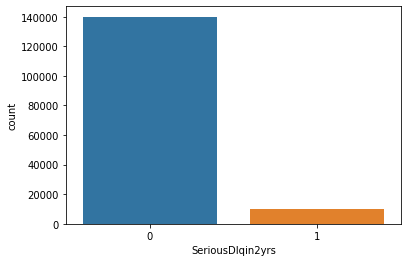

In [4]:
plt.figure()
sns.countplot(x="SeriousDlqin2yrs", data=credit)
plt.show()


可以看出，多数用户没有债务逾期，因此在建模时需要注意这是一个不平衡分类问题。

以10岁为一个年龄段，绘制每个年龄段的收入分布情况的箱形图。为了使得图表具有统计意义，仅选取年龄在20到90岁之间的样本。


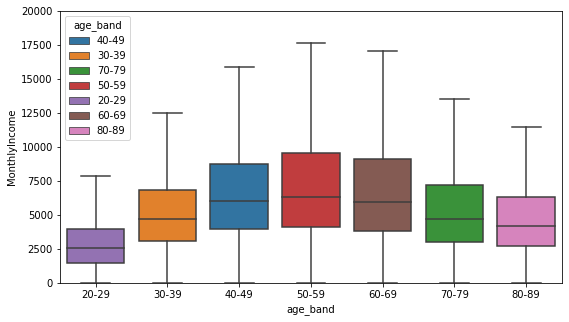

In [5]:
credit['age_band'] = (credit['age'] // 10 * 10).astype(np.str) + '-' + (credit['age'] // 10 * 10 + 9).astype(np.str)
plt.figure(figsize = (9,5))
sns.boxplot(x="age_band", y="MonthlyIncome", hue="age_band", data=credit[credit["age"].between(20, 89)], 
  order=np.sort(credit[credit["age"].between(20, 89)]['age_band'].unique()),dodge=False, showfliers=False)
plt.ylim(0, 2e4)
plt.show()
credit.drop("age_band", axis=1, inplace=True)



#### 2.1 年龄与月花销占月收入比例对债务逾期的影响

绘制两年内是否有过90天以上的债务逾期用户的月收入分布概率密度图。


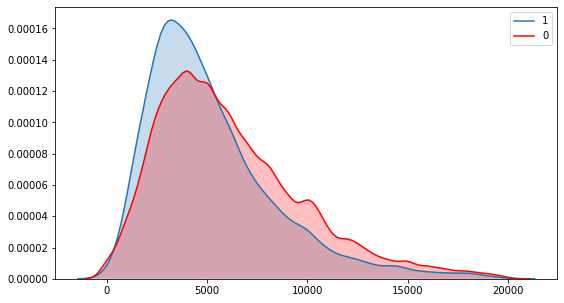

In [6]:
plt.figure(figsize = (9,5))
sns.kdeplot(credit[credit["SeriousDlqin2yrs"]==1]["MonthlyIncome"], shade=True, label="1", clip=(0,2e4))
sns.kdeplot(credit[credit["SeriousDlqin2yrs"]==0]["MonthlyIncome"], color="r", shade=True, label="0", clip=(0,2e4))
plt.show()


可以看出，逾期用户的月收入较低。

绘制两年内有过90天以上的债务逾期用户按月收入和月花销占月收入比例的热力图。


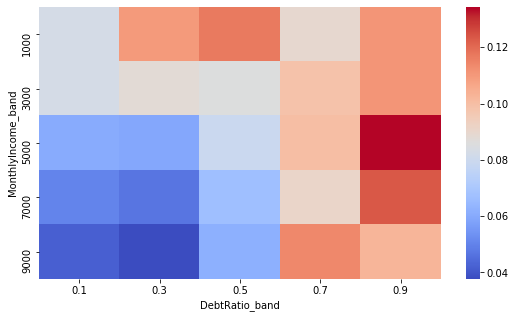

In [7]:
credit['MonthlyIncome_band'] = pd.cut(credit['MonthlyIncome'], range(0,12000,2000), labels=range(1000,11000,2000))
credit['DebtRatio_band'] = pd.cut(credit['DebtRatio'], [0,0.2,0.4,0.6,0.8,1], labels=[0.1,0.3,0.5,0.7,0.9])
data = credit.pivot_table(index='MonthlyIncome_band', columns='DebtRatio_band', values='SeriousDlqin2yrs', aggfunc='mean')
plt.figure(figsize = (9,5))
sns.heatmap(data , cmap="coolwarm")
plt.show()
credit.drop("MonthlyIncome_band", axis=1, inplace=True)
credit.drop("DebtRatio_band", axis=1, inplace=True)


可以看出，逾期用户的月收入较低且月花销占月收入比例较高。

### 3. 数据预处理

#### 3.1. 划分训练和测试集

随机抽取70%的样本作为训练集。

In [8]:
X = credit.drop(['SeriousDlqin2yrs'],axis=1)
y = credit['SeriousDlqin2yrs'] 
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 123)


#### 3.2. 数据填充

在前几节中，可以看出变量`MonthlyIncome`和`NumberOfDependents`存在缺失值。

* 将变量`MonthlyIncome`的缺失值用中位数填充；
* 将变量`NumberOfDependents`的缺失值用常数0填充。


In [9]:
imp_median = SimpleImputer(strategy='median')
train_X[['MonthlyIncome']] = imp_median.fit_transform(train_X[['MonthlyIncome']])
train_X['NumberOfDependents'] = train_X['NumberOfDependents'].fillna(0)


对测试集做同样的数据预处理。


In [10]:
test_X[['MonthlyIncome']] = imp_median.transform(test_X[['MonthlyIncome']])
test_X['NumberOfDependents'] = test_X['NumberOfDependents'].fillna(0)


### 4. 特征选择

创建特征选择器，计算每个预测变量对于目标变量的F值。


In [11]:
skb = SelectKBest(f_classif, k="all")
skb.fit(train_X, train_y)
scores = pd.DataFrame({'feature':np.array(train_X.columns), 'score':skb.scores_})
scores.sort_values("score", ascending = False, inplace=True)
scores

,feature,score
2,NumberOfTime30-59DaysPastDueNotWorse,1606.825799
6,NumberOfTimes90DaysLate,1390.206425
1,age,1365.113142
8,NumberOfTime60-89DaysPastDueNotWorse,1050.413641
9,NumberOfDependents,217.347645
5,NumberOfOpenCreditLinesAndLoans,77.690684
4,MonthlyIncome,53.902856
3,DebtRatio,9.010734
7,NumberRealEstateLoansOrLines,3.316268
0,RevolvingUtilizationOfUnsecuredLines,0.015121



可以看出，几乎所有变量都存在一定的预测能力。

### 5. 建立决策树模型

#### 5.1. 超参数调优

定义决策树分类模型，设置网格搜索超参数最大深度（`maxdepth`）和最小掺杂度减少比例（`min_impurity_decrease`），设置重采样策略为3折交叉验证，设置优化指标为ROC曲线下面积（`roc_auc`）。在训练集上做超参数调优。


In [12]:
clf = DecisionTreeClassifier()
param_grid = {'max_depth': [5,6,7], 'min_impurity_decrease': [0.00001,0.0001]}
gs = GridSearchCV(clf, param_grid, 'roc_auc', cv = 3)
gs.fit(train_X, train_y)
cv_results = pd.DataFrame(gs.cv_results_)
gs.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=1e-05, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


可以看出，最佳的超参数组合最大深度（`maxdepth`）为6且最小掺杂度减少比例（`min_impurity_decrease`）为0.00001。

可视化超参数调优结果。


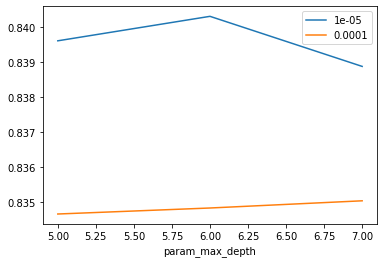

In [13]:
fig, ax = plt.subplots()
grouped = cv_results.groupby('param_min_impurity_decrease')
for key, group in grouped:
    group.plot(ax=ax, x='param_max_depth', y='mean_test_score', label=key)
plt.show()


#### 5.2. 模型训练

使用最优的超参数组合在训练集上做模型训练。


In [14]:
clf = gs.best_estimator_
clf.fit(train_X, train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=1e-05, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


绘制决策树。


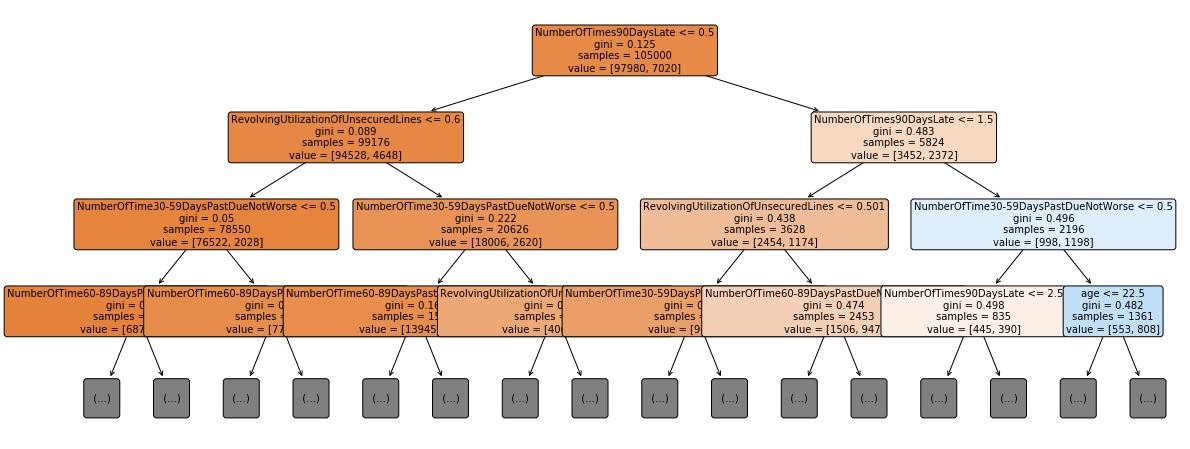

In [15]:
plt.figure(figsize = (20,8))
plot_tree(clf, max_depth=3, feature_names=np.array(train_X.columns), filled=True, rounded=True, fontsize=10)
plt.show()


#### 5.3. 模型测试

在测试集上做模型测试。


In [16]:
predict_y = clf.predict(test_X)
probas_y = clf.predict_proba(test_X)


评估模型性能。


In [17]:
accuracy_score(test_y, predict_y)

0.9366

In [18]:
roc_auc_score(test_y, probas_y[:, 1])

0.8558041122752035

In [19]:
f1_score(test_y, predict_y)

0.2768060836501901

In [20]:
fpr, tpr, thresholds = roc_curve(test_y, probas_y[:, 1])


绘制ROC曲线。


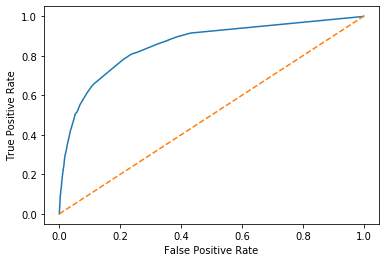

In [21]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


### 6. 建立梯度提升机模型

#### 6.1. 超参数调优

定义梯度提升机分类模型，设置网格搜索叶节点最小样本数（`min_samples_leaf `）和初始学习率（`learning_rate`），设置重采样策略为3折交叉验证，设置优化指标为ROC曲线下面积（`auc`）。在训练集上做超参数调优。


In [22]:
clf = GradientBoostingClassifier()
param_grid = {'min_samples_leaf': [10,20,50], 'learning_rate': [0.1,0.5]}
gs = GridSearchCV(clf, param_grid, 'roc_auc', cv = 3)
gs.fit(train_X, train_y)
cv_results = pd.DataFrame(gs.cv_results_)
gs.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=50, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


可以看出，最佳的超参数组合叶节点最小样本数（`min_samples_leaf`）为50且初始学习率（`learning_rate`）为0.1。

可视化超参数调优结果。


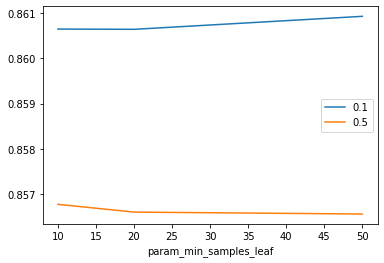

In [23]:
fig, ax = plt.subplots()
grouped = cv_results.groupby('param_learning_rate')
for key, group in grouped:
    group.plot(ax=ax, x='param_min_samples_leaf', y='mean_test_score', label=key)
plt.show()


#### 6.2. 模型训练

使用最优的超参数组合在训练集上做模型训练。


In [24]:
clf = gs.best_estimator_
clf.fit(train_X, train_y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=50, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


#### 6.3. 模型测试

在测试集上做模型测试。


In [25]:
predict_y = clf.predict(test_X)
probas_y = clf.predict_proba(test_X)


评估模型性能。


In [26]:
accuracy_score(test_y, predict_y)

0.9373333333333334

In [27]:
roc_auc_score(test_y, probas_y[:, 1])

0.8732356135152343

In [28]:
f1_score(test_y, predict_y)

0.3005952380952381

In [29]:
fpr, tpr, thresholds = roc_curve(test_y, probas_y[:, 1])


绘制ROC曲线。


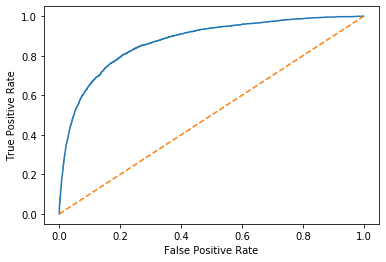

In [30]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()